<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-emm-gl/blob/main/Notebook2_KMeans_A01320739.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ACTIVIDAD SEMANAL 7 -- REGRESIONES Y K MEANS
##NOTEBOOK 2 -  K MEANS 

###Emmanuel Gonzalez Calitl

###A01320739



Materia: Ciencia y Analítica de Datos 

Profesora titular: Doc. María de la Paz Rico Fernández

Profesor tutor: Orlando Figón Cruz 

Fecha de entrega: 09 de Noviembre de 2022

Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber dónde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 492 kB/s 
     |████████████████████████████████| 1.0 MB 48.4 MB/s 
     |████████████████████████████████| 1.7 MB 42.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 32.7 MB/s 
     |████████████████████████████████| 6.3 MB 38.7 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=fe11c72de46c22f9028c6e7e5bac1c297eeaa87133fc2e6ff2f0afbbfce01c96
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=6e29e24a66f1ab536ec8a5475bb413b6086df6dd6c95c1f6c8cf3890861ee064
  Stored in directory: /root/.

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importar la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Explorar los datos

In [4]:
df.head()

,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


In [6]:
df.shape

(1839, 6)

**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [7]:
latlong=df[["latitude","longitude"]]
latlong

,latitude,longitude
0,33.224225,-86.804174
1,33.334550,-86.989778
2,30.602875,-87.895932
3,34.560148,-86.971559
4,31.266061,-85.446422
...,...,...
1834,43.034293,-88.176840
1835,42.989604,-88.259806
1836,42.846799,-106.264166
1837,41.162019,-104.800048


¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

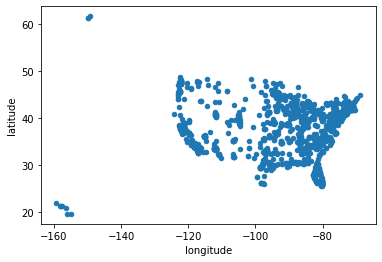

In [8]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [9]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [11]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [12]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [13]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [14]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

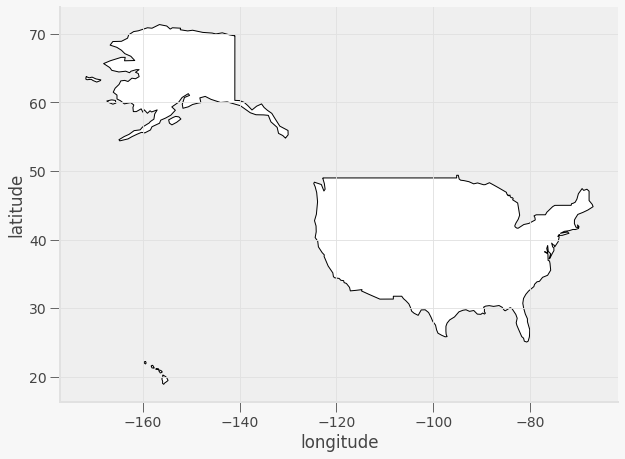

In [15]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

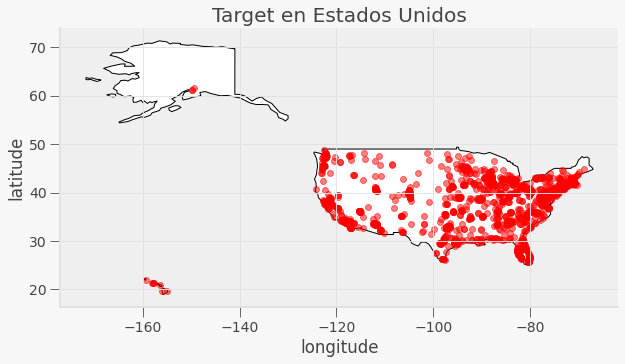

In [16]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

La agrupación de clusters es la agrupación de casos en un conjunto de datos en clústeres que tienen características similares. 

Un número de destino K indica el número de centroides en el conjunto de datos. Un centroide hace referencia a un punto representativo de cada clúster. 

Después, coloca cada datapoint en su cluster más cercano. 

###Encuentra el numero ideal de almacenes, justifica tu respuesta:

In [27]:
from sklearn.cluster import KMeans


k_clusters = range(1,5)  
k_means = [KMeans(n_clusters=i) for i in k_clusters]  
Y = latlong[['latitude']]
X = latlong[['longitude']]
score = [k_means[i].fit(Y).score(Y) for i in range(len(k_means))] 


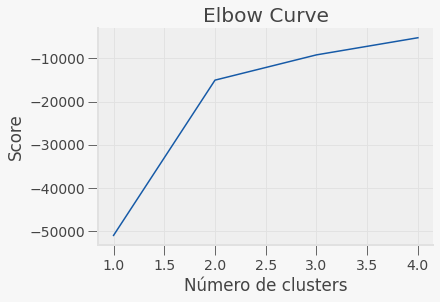

In [28]:
plt.plot(k_clusters, score)
plt.xlabel('Número de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

1. ¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.

La grafica elbow curve nos muestra el numero ideal de los almacenes (k) conforme a la cantidad de tiendas y las ubicaciones. Se selecciona el dato antes de que la grafica comience a deacaer, en este caso el 3.

### 2. Encuentra las latitudes y longitudes de los almacenes

In [29]:
k_means = KMeans(n_clusters = 3) 
k_means.fit(latlong[latlong.columns[0:2]])
labels = k_means.labels_
labels 

array([2, 2, 2, ..., 0, 2, 0], dtype=int32)

In [30]:
Xx = df[["longitude","latitude"]]

k_means = KMeans(n_clusters=3).fit(Xx)
labels = k_means.predict(Xx) 

centroides = k_means.cluster_centers_
centroides  

array([[ -78.56990807,   37.789554  ],
       [-118.62447332,   37.48734203],
       [ -93.3271723 ,   37.98006261]])

In [31]:

coord = pd.DataFrame(centroides)
coord["Coordenadas"] = list(zip(coord[0], coord[1]))
coord["Coordenadas"] = coord["Coordenadas"].apply(Point) 

geopanda_df= gpd.GeoDataFrame(coord, geometry="Coordenadas") 
geopanda_df

,0,1,Coordenadas
0,-78.569908,37.789554,POINT (-78.56991 37.78955)
1,-118.624473,37.487342,POINT (-118.62447 37.48734)
2,-93.327172,37.980063,POINT (-93.32717 37.98006)


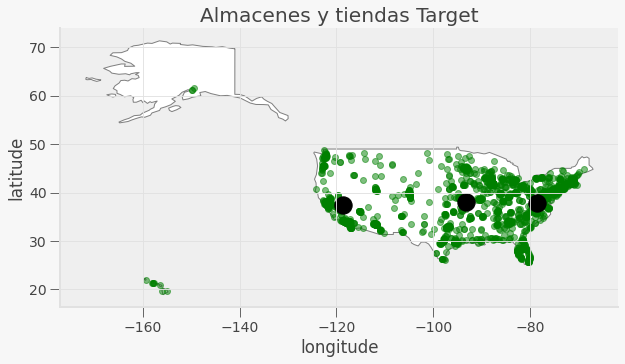

In [35]:
fig, gax = plt.subplots(figsize=(10,10))


world.query("name == 'United States of America'").plot(ax = gax, edgecolor='gray', color='white') 


gdf.plot(ax=gax, color='green', alpha = 0.5) 
geopanda_df.plot(ax=gax, color='black', alpha = 1, markersize = 300)  


gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Almacenes y tiendas Target')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Los puntos azules son todas las tiendas de Target en Estados Unidos, mientras que los puntos rojos indican la ubicación adecuada para los nuevos 3 almacenes. 

In [36]:

latlong['kmeans'] = k_means.labels_ 
latlong.loc[:, 'kmeans'].value_counts() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    826
2    628
1    385
Name: kmeans, dtype: int64

In [37]:
Almacen_1 = str(geopanda_df[1][0]) + ", " + str(geopanda_df[0][0])
print('Coordenadas de almacén 1:',Almacen_1)
Almacen_2 = str(geopanda_df[1][1]) + ", " + str(geopanda_df[0][1])
print('Coordenadas de almacén 2:',Almacen_2)
Almacen_3 = str(geopanda_df[1][2]) + ", " + str(geopanda_df[0][2])
print('Coordenadas de almacén 3:',Almacen_3)

Coordenadas de almacén 1: 37.789554004474006, -78.56990807484885
Coordenadas de almacén 2: 37.48734203064935, -118.62447331844157
Coordenadas de almacén 3: 37.98006260590112, -93.32717230430622


In [39]:
from geopy.geocoders.yandex import Location #esta liberia nos ayuda a localizar paises, ciudades, direccione
from geopy.geocoders import Nominatim #
from geopy.distance import geodesic # la distancia real entre dos puntos 

geolocator = Nominatim(user_agent="my-application") 


Almacenes = [Almacen_1,Almacen_2,Almacen_3]

print("Ciudades seleccionadas para construir los almacenes de Target")
for i in Almacenes:
  ubi = geolocator.reverse(i) 
  print(ubi.address)


Ciudades seleccionadas para construir los almacenes de Target
Langhorne Road, Totier Hills, Albemarle County, Virginia, 22946, United States
Paradise Estates, Mono County, California, United States
Hickory County, Missouri, United States


1. ¿Qué ciudad es?, ¿a cuantas tiendas va surtir?

Según los resultados obtenidos, los almacenes se podrían ubicar en: 

Almacén 1: Langhorne Road, Totier Hills, Albemarle County, Virginia y sería proveedor de 826 tiendas. 

Almacén 2: Paradise Estates, Mono County, California y sería proveedor de 385 tiendas. 

Almacén 3: Hickory County, Missouri y sería proveedor de 628 tiendas. 


2. ¿Sabes a que distancia estará?

In [26]:
distancia23 = str(geodesic(Almacen_2, Almacen_3).kilometers)
print("Distancia entre el Almacen 2 (California) y el Almacen 3 (Missouri):", distancia23, 'kilometros')

distancia31 = str(geodesic(Almacen_3, Almacen_1).kilometers)
print("Distancia entre el Almacen 3 (Missouri) y el Almacen 1 (Virginia):", distancia31, 'kilometros')

distancia21 = str(geodesic(Almacen_2, Almacen_1).kilometers)
print("Distancia entre el Almacen 2 (California) y el Almacen 1 (Virginia):", distancia21, 'kilometros')

Distancia entre el Almacen 2 (California) y el Almacen 3 (Missouri): 2223.726700333532 kilometros
Distancia entre el Almacen 3 (Missouri) y el Almacen 1 (Virginia): 1297.004040608758 kilometros
Distancia entre el Almacen 2 (California) y el Almacen 1 (Virginia): 3507.813810910429 kilometros


¿Consideras importante que se grafique en un mapa?, ¿por qué?

Sí claro porque siempre la información preseentada de manera gráfica es más facil de asimilar y presentar. Asi como analizar por personas.